# Rainfall variability

Code and text partially sourced from Ridge to Reef Chapter 2. Here are the pending to-dos:

- [ ] Which 3-5 stations to use? Determine using robust, reproducible method.
- [ ] Add the following to the metadata file: Start and end year for each station; number of missing data points; improve location accuracy for flagged stations
- [ ] Figure out which alpha, lambda values are needed: by month? by year? or just average? Get these values for the 3-5 stations that we'll use for the paper.


Last updated: 5 February 2020

## 1. Import model

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import sys

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# os.chdir("../")

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.make_climate_parameters import make_climate_parameters

In [2]:
alpha_r, lambda_r = make_climate_parameters()

climate = Climate(alpha_r, lambda_r)
soil = Soil('loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run(planting_date=100)

o = model.output()
o['dos'].plot()
#model.output()

79 0
80 1
81 2
82 3
83 4
84 5
85 6
86 7
87 8
88 9
89 10
90 11
91 12
92 13
93 14
94 15
95 16
96 17
97 18
98 19
99 20
100 21
101 22
102 23
103 24
104 25
105 26
106 27
107 28
108 29
109 30
110 31
111 32
112 33
113 34
114 35
115 36
116 37
117 38
118 39
119 40
120 41
121 42
122 43
123 44
124 45
125 46
126 47
127 48
128 49
129 50
130 51
131 52
132 53
133 54
134 55
135 56
136 57
137 58
138 59
139 60
140 61
141 62
142 63
143 64
144 65
145 66
146 67
147 68
148 69
149 70
150 71
151 72
152 73
153 74
154 75
155 76
156 77
157 78
158 79
159 80
160 81
161 82
162 83
163 84
164 85
165 86
166 87
167 88
168 89
169 90
170 91
171 92
172 93
173 94
174 95
175 96
176 97
177 98
178 99
179 100
180 101
181 102
182 103
183 104
184 105
185 106
186 107
187 108
188 109
189 110
190 111
191 112
192 113
193 114
194 115
195 116
196 117
197 118
198 119
199 120
200 121
201 122
202 123
203 124
204 125
205 126
206 127
207 128
208 129
209 130
210 131
211 132
212 133
213 134
214 135
215 136
216 137
217 138
218 139
219 140
220

AttributeError: 'CropModel' object has no attribute 'doy'

## 2. Simulate rainfall totals

Using a $\lambda_r$ value of <code>0.40</code>, and assuming that the length of a growing season, $T_{seas}$, is 100 days, simulate a season of rainfall "events", where the value of a day is <code>1</code> if rainfall occurs, and <code>0</code> if not.

In [ ]:
T_seas = 100 # Days in each season
N_seas = 100 # Number of seasons to simulate
alpha = 11
s_mat = np.random.uniform(low=0, high=1, size=[N_seas, T_seas])
amounts = np.random.exponential(scale=alpha, size=[N_seas, T_seas])

lam = 0.4 # Lambda value
rain_days = np.array(s_mat <= lam).astype(int)
rain = rain_days * amounts
rain.sum(axis=1).std()/rain.sum(axis=1).mean() # Analytical equation for this!

### Prepare historical rainfall using CETRAD dataset

In [9]:
from datetime import datetime
from dateutil.relativedelta import *

df = pd.read_csv("../data/CETRAD/CETRAD_rainfall.csv")  # Read in the raw csv data.

# Step 1. Convert text strings into datetime objects.
format = '%m/%d/%y' # Column RDate has data in M/D/YY
df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
df['Year'] = [dt.year for dt in df['Datetime']]
df['Month'] = [dt.month for dt in df['Datetime']]

# Step 4. Use the Datetime values as the index for this dataframe.
df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

# Step 5.  Delete the old RDate column, which we no longer need. 
# We will keep the Datetime column, in case we need it later.
df = df.drop(['RDate'], axis=1)

In [10]:
df.head()
df.tail()
station_list = [station for station in df.columns if station not in ['Year', 'Day', 'Month', 'Datetime']]
print(station_list)

['ARCHERS POST', 'ARDENCAPLE FARM', 'CASTLE FOREST STN', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN', 'COLCHECCIO', 'DOL DOL DAO', 'EL KARAMA', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'GATHIURU FOREST STN', 'HOMBE FOREST STN', 'IRANGI FOREST STN', 'ISIOLO DAO', 'JACOBSON FARM', 'JUNCTION (EWASO NAROK)', 'KABARU FOREST STN', 'KAGURU', 'KALALU (NRM)', 'KAMWAKI FARM', 'KARURI (NRM)', 'KINAMBA MOW', 'KISIMA FARM', 'LAMURIA MET STN', 'LARIAK FOREST STN', 'LOGILADO (NRM)', 'LOLDAIGA FARM', 'LOLDOTO FARM', 'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS', 'MATANYA (NRM)', 'MERU FOREST STN', 'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH', 'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MURINGATO FOREST STN', 'MUTARA ADC FARM', 'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NANYUKI KAF', 'NARO MORU FG POST', 'NARO MORU FOREST STN', 'NARO MORU GATE STN', 'NARO MORU MET STN', 'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM', 'NYERI MOW', 'OL ARABEL FOREST STN

### Step 1. Select stations for use
For brevity in this document, stations were combined into one dataframe and annual rainfall totals were calculated in another csv which is brought back in here. The original objective is to select three representative stations of low, medium, and high total rainfall for the study region. And then calculate alphas, lambdas using those records.

In [ ]:
# Import cleaned, merged datasets
AnnualRainfall = pd.read_csv("../data/CETRAD/AnnualRainfall.csv")  # Read in the Annual Rainfall per station
AnnualRainfall.head()

In [ ]:
# Import metadata for the stations
md = pd.read_csv("../data/CETRAD/CETRADMetadata.csv")  # Read in the each stations metadata
md.head()

In [ ]:
md.describe()

In [ ]:
# Return min, max, med:
md.sort_values(by='Annual Mean Rainfall')

# stations to use:
# L: OL JOGI FARM: 1967-1999, 32 years
# M: Kisima Farm
# H: TIMAU MARANIA: 1951-2015, # 64 years

### Step 2. Filter data

TODO: Put the three locations in a list and loop through the following procedure to determine r2, etc.

In [11]:
#station = 'ARDENCAPLE FARM' # 67 years of data
#station = 'JACOBSON FARM'
#station = 'EMBORI FARM'
station = 'OL JOGI FARM'
#station = 'TIMAU MARANIA'
columns = [station] + ['Year', 'Month', 'Datetime']
rainfall = df[columns]
rainfall.head()

,OL JOGI FARM,Year,Month,Datetime
Datetime,,,,
1934-01-01,NaN,1934,1,1934-01-01
1934-01-02,NaN,1934,1,1934-01-02
1934-01-03,NaN,1934,1,1934-01-03
1934-01-04,NaN,1934,1,1934-01-04
1934-01-05,NaN,1934,1,1934-01-05


Check out the data

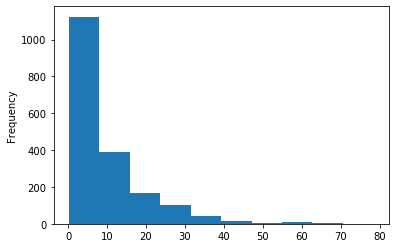

In [12]:
# Plot a histogram of rainfall values for days with rain.
daily_rainfall = rainfall.loc[rainfall[station] > 0][station]
daily_rainfall.plot.hist()

This looks okay, but we need to check and see how well the values in `daily_rainfall` fit our assumption of an exponential distribution.

### Step 3. Fit the distribution

To fit the distribution, we are going to use some more functions from `python`'s suite of numerical analysis. In this case we are going to use some functions from `scipy`. The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) module has a large suite of distribution functions pre-defined, which we can use to develop a fit for our data. Using any of these distributions for fitting our data is very easy. The distribution we are most interested in is the exponential distribution, which is called `expon` in the `stats` module.

In [14]:
import scipy.stats as st

distribution = st.expon
data = daily_rainfall
params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

print(params)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

(0.2, 9.355624327233585)


### Step 4. Calculate fitted PDF and error with fit in distribution

To test the fit of our distribution, we can compare the empirical histogram to that predicted by our model. To do this, we first use our `data` to generate the empirical histogram. In this exampkle, we break the data into `30` bins, and we generate a histrogram of `density` rather than counts. This allows for an easier comparison between our empirical data and the fitted probability distribution function. Here are the steps:

1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
2. Shift the `x` bin locations generated from the histogram to the center of bins.
3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according to:

$$ SS_{error} = \sum_{i=1}^{n} \left(y_i - f(x_i)\right)^2 $$
$$ SS_{yy} = \sum_{i=1}^{n} \left(y_i - \bar{y}\right)^2 $$

5. Calculate the $r^2$ of the fit, according to

$$ r^2 = 1- \frac{SS_{error}}{SS_{yy}} $$ 

 

In [15]:
# Step 1. Generate a density histogram of the data 
y, x = np.histogram(data, bins=30, density=True)

# Step 2. Shift the x bin locations to the center of bins.
x = (x + np.roll(x, -1))[:-1] / 2.0

# Step 3. Calculate the values of pdx(x) for all x.
pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

# Step 4. Determine the residual and total sum of the squares.
ss_error = np.sum(np.power(y - pdf, 2.0))
ss_yy = np.sum(np.power(y - y.mean(), 2.0))

r_2 = 1 - ( ss_error / ss_yy )
print(r_2)

0.978217870115316


This is an extremely good fit, so we can be confident that our assumption about an exponential distribution of rainfall is reasonable.

## Determining monthly values of  $\lambda_r$ 

We need to determine the probability of rainfall for each month by dividing the number of rainy days per month by the total number of observations in each month. For now, we assume stationarity in the monthly values, which means that we are assuming that the values of $\lambda_r$ in each month are the same through out the entire record (i.e. Jan 1938 has the same properties as Jan 2008). 

<div class="alert alert-info">💡 Test stationarity assumption </div>



As a first step, let's get all the `rain_days` and all of the `observation_days` from the data on `OL JOGI FARM`. We will use method chaining to run a **groupby()** as we go.

In [16]:
# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall[station] > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall[station] >= 0]

rain_days.head()

,OL JOGI FARM,Year,Month,Datetime
Datetime,,,,
1967-03-01,3.8,1967,3,1967-03-01
1967-03-02,50.7,1967,3,1967-03-02
1967-03-03,7.6,1967,3,1967-03-03
1967-03-21,1.0,1967,3,1967-03-21
1967-03-30,34.7,1967,3,1967-03-30


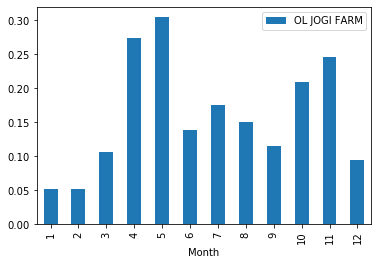

In [17]:
lambda_by_month = (
    rain_days.groupby('Month')[station].count() /
    all_days.groupby('Month')[station].count()
    )
pd.DataFrame(lambda_by_month).plot.bar()

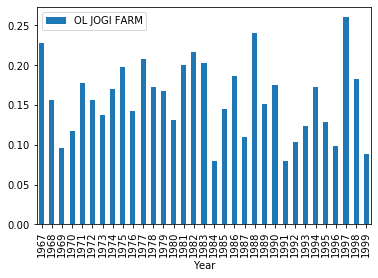

In [18]:
lambda_by_year = (
    rain_days.groupby('Year')[station].count() /
    all_days.groupby('Year')[station].count()
    )
pd.DataFrame(lambda_by_year).plot.bar()

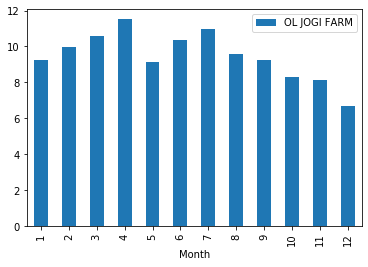

In [19]:
alpha_by_month = rain_days.groupby('Month')[station].mean()
pd.DataFrame(alpha_by_month).plot.bar()

In [83]:
climate = pd.DataFrame(alpha_by_month)
climate = climate.rename(columns={'OL JOGI FARM': 'alpha_by_month'})
climate['lambda_by_month'] = lambda_by_month
climate['days'] = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
climate['monthly_rainfall'] = climate['lambda_by_month'] * climate['alpha_by_month'] * climate['days']


climate_parameters = {
     'alpha_r': climate['alpha_by_month'].to_list(),
    'lambda_r': climate['lambda_by_month'].to_list(),
    'doy_start': 1,
    't_sim': 180,
    'ET_max': 6.5
}

#dir(climate['alpha_by_month'])


climate = Climate(climate_parameters)

climate.rainfall.sum()

245.95189013729302

SyntaxError: invalid syntax (make_climate.py, line 96)

## Simulating annual rainfall

To simulate annual rainfall, we are going to specify daily values of $\lambda_r$ using the monthly values we just calculated. The use of a variable $\lambda$ value in a poisson process creates what is known as an "inhomogenous poisson process" (or, alternatively, "nonhomogeneous"... unfortunately, there isn't much homogeneity in what we call it!). These types of processes allow the properties of the process to change in space and time. Our implementation - using monthly values - is a little clunky, and we'd prefer to have the $\lambda$ values change more smoothly throughout the year. However, we probably don't have sufficient data to allow for this, even if we could accomodate the more complicated coding it would require. 

In order to generate our nonhomogenous process we will first generate a daily array of month numbers for the year `2018`. This is really easy in python using `datetime` + `timedelta` (which we need to import).

```python
    import datetime
    from datetime import timedelta
    datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
    month_value = np.array([datetime.month for datetime in datetimes])
```

In [ ]:
from datetime import timedelta, datetime
datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

## ToDo #1
## turn this into dekad_value_by_day

In [ ]:
print(lambda_by_month)

## To-Do #1
## turn this into lambda_by_dekad

## To-Do #2
## turn this into plot, and plot for each station 
lambda_by_month.plot(kind='bar')

In [ ]:
print(month_value_by_day)

`numpy` makes it really easy to map the values in one array onto the values of another.

```python
    lambda_values = [lambda_by_month[i] for i in month_value_by_day]
```

In [ ]:
lambda_values = np.array([lambda_by_month[i] for i in month_value_by_day])

With daily values of $\lambda_r$, we only need to follow the same cookbook we used to make the seasonal data:

```python
    alpha = scale  # Let's use the value we estimated from our exponential fit.
    simulated_rainfall_values = np.random.exponential(
        scale=alpha, size=len(lambda_values)) # Use the len() function instead of a constant.
```

    

In [ ]:
alpha = scale

simulated_rainy_days = (np.random.uniform(low=0, high=1, size=len(lambda_values)) <= lambda_values).astype(int)
simulated_rainfall_values = np.random.exponential(scale=alpha, size=len(lambda_values))

simulated_rainfall = simulated_rainy_days * simulated_rainfall_values

## Plotting our simulated data

We can easily plot our rainfall data using the `datetimes` object we already created as the basis of our x-axis.

In [ ]:
fig, ax = plt.subplots()

ax.bar(datetimes, simulated_rainfall, align='center', alpha=0.5)

<div class="alert alert-success">✏️ <strong>DIY Coding</strong>: Play around with our simulation. Here are a couple of ideas:</div>

1. Run 100 simulations of rainfall with our model for `JACOBSON FARM`. Compare the distribution of annual rainfall to the empirical distribution of annual rainfall.

2. Run the model for the same number of years that are in the `JACOBSON FARM` record and compare the mean and standard deviations of annual rainfall between the simulation and the empirical data. How well do they match?

2. Using the same simulations as in `2`, compare the mean and standard deviations of monthly rainfall between the simulation and the empirical data.

3. We've made $\lambda_r$ change every month, but we've used a constant $\alpha$ value. Determine if the assumption of a constant $\alpha$ is reasonable.

4. Determine the model parameters for a different station, preferably one with much lower or higher rainfall. How do the values of $\alpha$ and $\lambda_r$ change between stations?

5. Earlier I touched on the idea of non-stationarity in which the values of $\lambda_r$ and/or $\alpha$ may be changing over time. If you're up for it, see if you can come up with a way to investigate if our assumption of stationarity is valid.
